🧩 Overview — What this Colab script will do

Fetch hourly data from Open-Meteo
 for:

Air quality (pm2_5, pm10, no2, o3, so2, co)

Weather (temperature_2m, relative_humidity_2m, surface_pressure, wind_speed_10m, wind_direction_10m)

Loop month-by-month to safely fetch 1 year (avoid timeout or large responses).

Merge both datasets on timestamps.

Clean & standardize columns.

Save to CSV/Parquet (for now, in Colab).

next step (feature creation → Hopsworks insert).

Coordinates of khi:
latitude = 24.8607
longitude = 67.0011


In [ ]:
# ======================================
# 1️⃣ Install dependencies
# ======================================
!pip install pandas requests tqdm pyarrow --quiet

import pandas as pd
import requests
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm


In [ ]:

# ======================================
# 2️⃣ Configurations
# ======================================
latitude = 24.8607    # khi
longitude = 67.0011
start_date = date(2024, 1, 1)
end_date = date(2025, 1, 1)

# base urls
URL_WEATHER = "https://archive-api.open-meteo.com/v1/archive"
URL_AIR = "https://air-quality-api.open-meteo.com/v1/air-quality"


In [ ]:

# ======================================
# 3️⃣ Helper function to fetch a monthly chunk
# ======================================
def fetch_open_meteo_chunk(lat, lon, start_dt, end_dt):
    """Fetch weather + air-quality data for a date range (1 month typical)"""

    params_weather = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_dt.isoformat(),
        "end_date": end_dt.isoformat(),
        "hourly": ["temperature_2m", "relative_humidity_2m", "surface_pressure",
                   "wind_speed_10m", "wind_direction_10m"],
        "timezone": "auto"
    }

    params_air = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_dt.isoformat(),
        "end_date": end_dt.isoformat(),
        "hourly": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide",
                   "sulphur_dioxide", "ozone"],
        "timezone": "auto"
    }

    # fetch both
    w = requests.get(URL_WEATHER, params=params_weather).json()
    a = requests.get(URL_AIR, params=params_air).json()

    # convert to DataFrames
    df_weather = pd.DataFrame(w["hourly"])
    df_air = pd.DataFrame(a["hourly"])

    # merge on time
    df = pd.merge(df_weather, df_air, on="time", how="outer")
    df["time"] = pd.to_datetime(df["time"])
    return df.sort_values("time")


In [ ]:

# ======================================
# 4️⃣ Loop for 12 months (1 year backfill)
# ======================================
frames = []
current = start_date
while current < end_date:
    chunk_end = min(current + relativedelta(months=1) - timedelta(days=1), end_date)
    print(f"Fetching {current} → {chunk_end}")
    df_chunk = fetch_open_meteo_chunk(latitude, longitude, current, chunk_end)
    frames.append(df_chunk)
    current += relativedelta(months=1)

# combine all months
df_all = pd.concat(frames, ignore_index=True)
df_all = df_all.drop_duplicates(subset=["time"]).sort_values("time")



Fetching 2024-01-01 → 2024-01-31
Fetching 2024-02-01 → 2024-02-29
Fetching 2024-03-01 → 2024-03-31
Fetching 2024-04-01 → 2024-04-30
Fetching 2024-05-01 → 2024-05-31
Fetching 2024-06-01 → 2024-06-30
Fetching 2024-07-01 → 2024-07-31
Fetching 2024-08-01 → 2024-08-31
Fetching 2024-09-01 → 2024-09-30
Fetching 2024-10-01 → 2024-10-31
Fetching 2024-11-01 → 2024-11-30
Fetching 2024-12-01 → 2024-12-31


In [ ]:
# ======================================
# 5️⃣ Basic cleaning / renaming
# ======================================
df_all.rename(columns={
    "time": "timestamp",
    "temperature_2m": "temp_C",
    "relative_humidity_2m": "humidity_percent",
    "surface_pressure": "pressure_hPa",
    "wind_speed_10m": "wind_speed_mps",
    "wind_direction_10m": "wind_deg",
    "pm2_5": "pm2_5_ugm3",
    "pm10": "pm10_ugm3",
    "carbon_monoxide": "co_ugm3",
    "nitrogen_dioxide": "no2_ugm3",
    "sulphur_dioxide": "so2_ugm3",
    "ozone": "o3_ugm3"
}, inplace=True)

# add city & coordinates
df_all["city"] = "karachi"
df_all["latitude"] = latitude
df_all["longitude"] = longitude

# reorder columns
cols = ["timestamp", "city", "latitude", "longitude",
        "temp_C", "humidity_percent", "pressure_hPa",
        "wind_speed_mps", "wind_deg",
        "pm2_5_ugm3", "pm10_ugm3", "co_ugm3", "no2_ugm3", "so2_ugm3", "o3_ugm3"]
df_all = df_all[cols]



In [ ]:
# ======================================
# 6️⃣ Save locally in Colab
# ======================================
df_all.to_csv("karachi_air_weather_2024.csv", index=False)
df_all.to_parquet("karachi_air_weather_2024.parquet", index=False)

print("✅ Done! Rows:", len(df_all))
df_all.head()


✅ Done! Rows: 8784


,timestamp,city,latitude,longitude,temp_C,humidity_percent,pressure_hPa,wind_speed_mps,wind_deg,pm2_5_ugm3,pm10_ugm3,co_ugm3,no2_ugm3,so2_ugm3,o3_ugm3
0,2024-01-01 00:00:00,karachi,24.8607,67.0011,17.8,53,1016.8,13.8,49,45.2,68.5,615.0,15.4,19.9,91.0
1,2024-01-01 01:00:00,karachi,24.8607,67.0011,17.2,56,1016.6,13.3,41,45.8,69.2,597.0,11.8,19.6,95.0
2,2024-01-01 02:00:00,karachi,24.8607,67.0011,16.8,57,1016.5,13.8,39,46.2,69.6,586.0,9.0,19.5,98.0
3,2024-01-01 03:00:00,karachi,24.8607,67.0011,16.4,59,1016.2,13.7,45,46.6,69.8,578.0,6.4,19.7,101.0
4,2024-01-01 04:00:00,karachi,24.8607,67.0011,15.9,62,1016.4,12.9,54,47.0,70.3,578.0,4.7,20.0,103.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
output_path = "/content/drive/MyDrive/air_quality_data/"
import os
os.makedirs(output_path, exist_ok=True)
df_all.to_csv(output_path + "karachi_air_weather_2024.csv", index=False)
df_all.to_parquet(output_path + "karachi_air_weather_2024.parquet", index=False)


Compute Features from Raw Data

In [ ]:
print(df_all.columns.tolist())


['timestamp', 'city', 'latitude', 'longitude', 'temp_C', 'humidity_percent', 'pressure_hPa', 'wind_speed_mps', 'wind_deg', 'pm2_5_ugm3', 'pm10_ugm3', 'co_ugm3', 'no2_ugm3', 'so2_ugm3', 'o3_ugm3']


In [ ]:
import os
import numpy as np

# load the raw merged file you created earlier
input_path = "/content/drive/MyDrive/air_quality_data/karachi_air_weather_2024.parquet"
df = pd.read_parquet(input_path)

# Ensure timestamp is datetime and sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Rename to simpler column names we'll use below
df = df.rename(columns={
    'temp_C': 'temp',
    'humidity_percent': 'humidity',
    'pressure_hPa': 'pressure',
    'wind_speed_mps': 'wind_speed',
    'wind_deg': 'wind_deg',
    'pm2_5_ugm3': 'pm25',
    'pm10_ugm3': 'pm10',
    'co_ugm3': 'co',
    'no2_ugm3': 'no2',
    'so2_ugm3': 'so2',
    'o3_ugm3': 'o3'
})

# --- 1) Time-based features ---
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# --- 2) Safe missing-value handling for numeric columns used in featurization ---
# we will not drop rows; instead keep NaNs so feature store keeps consistent schema.
numeric_cols = ['pm25','pm10','co','no2','so2','o3','temp','humidity','pressure','wind_speed']
for c in numeric_cols:
    if c not in df.columns:
        df[c] = np.nan
# optional: forward-fill small gaps for rolling computations (won't overwrite long gaps)
df[numeric_cols] = df[numeric_cols].ffill(limit=3)

# --- 3) AQI-related derived features ---
# hour-to-hour change of pm2.5 (proxy for AQI change rate). Keep NaN where not computable.
df['pm25_diff_1h'] = df['pm25'].diff()

# rolling means and stds (min_periods=1 to compute at start)
df['pm25_rollmean_6h'] = df['pm25'].rolling(window=6, min_periods=1).mean()
df['pm25_rollmean_24h'] = df['pm25'].rolling(window=24, min_periods=1).mean()
df['pm25_rollstd_24h'] = df['pm25'].rolling(window=24, min_periods=1).std().fillna(0.0)

# proportion relative to 24h mean (use safe divide)
df['pm25_over_24h_mean'] = df['pm25'] / (df['pm25_rollmean_24h'].replace({0: np.nan}))

# --- 4) Weather-interaction features ---
df['temp_x_humidity'] = df['temp'] * df['humidity']
# wind inverse: calm conditions (low wind) often correlate with worse AQI
df['wind_inverse'] = 1.0 / (df['wind_speed'].fillna(0.0) + 0.1)

# convert wind direction (cyclic) to sin/cos for ML
if 'wind_deg' in df.columns:
    df['wind_sin'] = np.sin(np.deg2rad(df['wind_deg'].fillna(0.0)))
    df['wind_cos'] = np.cos(np.deg2rad(df['wind_deg'].fillna(0.0)))
else:
    df['wind_sin'] = np.nan
    df['wind_cos'] = np.nan

# --- 5) Lag features (common lags for short-term forecasting) ---
df['pm25_lag_1h'] = df['pm25'].shift(1)
df['pm25_lag_3h'] = df['pm25'].shift(3)
df['pm25_lag_24h'] = df['pm25'].shift(24)

# you can add lags for other pollutants similarly if desired

# --- 6) Optional: flag rows with too many missing pollutant measurements (for QA) ---
df['pollutant_null_count'] = df[['pm25','pm10','no2','o3','so2','co']].isna().sum(axis=1)
# create a boolean flag: True if majority of pollutants missing
df['pollutant_data_sparse'] = (df['pollutant_null_count'] >= 4)

# --- 7) Reorder columns for readability and save ---
cols_prefer = ['timestamp','city','latitude','longitude',
               'pm25','pm10','no2','o3','so2','co',
               'pm25_lag_1h','pm25_lag_3h','pm25_lag_24h',
               'pm25_diff_1h','pm25_rollmean_6h','pm25_rollmean_24h','pm25_rollstd_24h','pm25_over_24h_mean',
               'temp','humidity','pressure','wind_speed','wind_deg','wind_sin','wind_cos','wind_inverse',
               'temp_x_humidity','hour','day_of_week','month','is_weekend',
               'pollutant_data_sparse']

# only keep existing columns in the above order
existing_cols = [c for c in cols_prefer if c in df.columns]
df_features = df[existing_cols].copy()

# create output folder and save
output_path = "/content/drive/MyDrive/air_quality_data/"
os.makedirs(output_path, exist_ok=True)
out_file = os.path.join(output_path, "karachi_air_features_2024.parquet")
df_features.to_parquet(out_file, index=False)

print("Feature file saved to:", out_file)
print("Rows:", len(df_features))
df_features.head(10)

Feature file saved to: /content/drive/MyDrive/air_quality_data/karachi_air_features_2024.parquet
Rows: 8784


,timestamp,city,latitude,longitude,pm25,pm10,no2,o3,so2,co,...,wind_deg,wind_sin,wind_cos,wind_inverse,temp_x_humidity,hour,day_of_week,month,is_weekend,pollutant_data_sparse
0,2024-01-01 00:00:00,karachi,24.8607,67.0011,45.2,68.5,15.4,91.0,19.9,615.0,...,49,0.754710,0.656059,0.071942,943.4,0,0,1,0,False
1,2024-01-01 01:00:00,karachi,24.8607,67.0011,45.8,69.2,11.8,95.0,19.6,597.0,...,41,0.656059,0.754710,0.074627,963.2,1,0,1,0,False
2,2024-01-01 02:00:00,karachi,24.8607,67.0011,46.2,69.6,9.0,98.0,19.5,586.0,...,39,0.629320,0.777146,0.071942,957.6,2,0,1,0,False
3,2024-01-01 03:00:00,karachi,24.8607,67.0011,46.6,69.8,6.4,101.0,19.7,578.0,...,45,0.707107,0.707107,0.072464,967.6,3,0,1,0,False
4,2024-01-01 04:00:00,karachi,24.8607,67.0011,47.0,70.3,4.7,103.0,20.0,578.0,...,54,0.809017,0.587785,0.076923,985.8,4,0,1,0,False
5,2024-01-01 05:00:00,karachi,24.8607,67.0011,46.2,68.9,6.7,97.0,19.9,598.0,...,61,0.874620,0.484810,0.083333,994.5,5,0,1,0,False
6,2024-01-01 06:00:00,karachi,24.8607,67.0011,47.1,70.1,14.8,89.0,20.4,689.0,...,60,0.866025,0.500000,0.080000,1005.0,6,0,1,0,False
7,2024-01-01 07:00:00,karachi,24.8607,67.0011,49.1,72.6,25.8,78.0,21.2,812.0,...,59,0.857167,0.515038,0.078740,999.6,7,0,1,0,False
8,2024-01-01 08:00:00,karachi,24.8607,67.0011,51.8,76.1,31.8,77.0,22.2,887.0,...,51,0.777146,0.629320,0.076336,1003.2,8,0,1,0,False
9,2024-01-01 09:00:00,karachi,24.8607,67.0011,53.0,77.5,28.3,95.0,23.6,872.0,...,44,0.694658,0.719340,0.082645,1003.2,9,0,1,0,False


Starting with HOPSWORKS


    

In [ ]:
!pip uninstall -y hopsworks hsfs
!pip install hopsworks==4.4.2 hsfs==3.7.9 --quiet

Found existing installation: hopsworks 4.2.0
Uninstalling hopsworks-4.2.0:
  Successfully uninstalled hopsworks-4.2.0
Found existing installation: hsfs 3.7.9
Uninstalling hsfs-3.7.9:
  Successfully uninstalled hsfs-3.7.9


In [ ]:
!pip install hopsworks
!pip install hopsworks==4.2
!pip install confluent-kafka

  Using cached hopsworks-4.2.0-py3-none-any.whl.metadata (11 kB)
Using cached hopsworks-4.2.0-py3-none-any.whl (660 kB)
  Attempting uninstall: hopsworks
    Found existing installation: hopsworks 4.4.2
    Uninstalling hopsworks-4.4.2:
      Successfully uninstalled hopsworks-4.4.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 43.9 MB/s eta 0:00:00


In [ ]:
#pip uninstall hopsworks hsfs

Found existing installation: hopsworks 4.4.2
Uninstalling hopsworks-4.4.2:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/hopsworks-4.4.2.dist-info/*
    /usr/local/lib/python3.12/dist-packages/hopsworks/*
    /usr/local/lib/python3.12/dist-packages/hopsworks_common/*
    /usr/local/lib/python3.12/dist-packages/hsfs/*
    /usr/local/lib/python3.12/dist-packages/hsml/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.12/dist-packages/hsfs/code.py
    /usr/local/lib/python3.12/dist-packages/hsfs/core/builtin_transformation_function.py
    /usr/local/lib/python3.12/dist-packages/hsfs/core/code_api.py
    /usr/local/lib/python3.12/dist-packages/hsfs/core/code_engine.py
    /usr/local/lib/python3.12/dist-packages/hsfs/transformation_function_attached.py
Proceed (Y/n)? y
  Successfully uninstalled hopsworks-4.4.2
Found existing installation: hsfs 3.7.9
Uninstalling hsfs-3.7.9:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/hsfs-3.7.9.dist-inf

In [ ]:
#pip install hopsworks

  Using cached hopsworks-4.4.2-py3-none-any.whl.metadata (11 kB)
Using cached hopsworks-4.4.2-py3-none-any.whl (691 kB)


In [ ]:
import hopsworks
import pandas as pd

# 🔑 Connect to your Hopsworks project
project = hopsworks.login(api_key_value="jUnWmY5gnbOgCTFa.mMZBk1yLzRJtocPY0Eq5alolUXu6sc1Ol2iFIO75SXZZaFCLdN4JY7i6ryPEV8yJ")
fs = project.get_feature_store()

# 📂 Load your dataset (from Drive or local)
# Example: Adjust path if your file is in Drive
data = pd.read_csv("/content/drive/MyDrive/air_quality_data/karachi_air_weather_2024.csv")

# 🧹 Ensure timestamp column is datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# 🧩 Create a Feature Group
feature_group = fs.get_or_create_feature_group(
    name="air_quality_features",
    version=1,
    primary_key=["city", "timestamp"],
    description="Weather and air-quality features for karachi (1-year historical data)"
)

# 🚀 Upload to Hopsworks Feature Store
feature_group.insert(data)




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'





Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271958



Uploading Dataframe: 100.00% |██████████| Rows 8784/8784 | Elapsed Time: 00:04 | Remaining Time: 00:00


Launching job: air_quality_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271958/jobs/named/air_quality_features_1_offline_fg_materialization/executions


(Job('air_quality_features_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
import hopsworks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# 🧠 Reconnect to your project
project = hopsworks.login(api_key_value="jUnWmY5gnbOgCTFa.mMZBk1yLzRJtocPY0Eq5alolUXu6sc1Ol2iFIO75SXZZaFCLdN4JY7i6ryPEV8yJ")
fs = project.get_feature_store()

# 📥 Load feature data from Feature Group
feature_group = fs.get_feature_group(name="air_quality_features", version=1)
df = feature_group.read()  # Reads offline data

# 🧹 Basic preprocessing
df = df.dropna()

# 🎯 Target and features
target = "pm2_5_ugm3"
X = df.drop(columns=[target, "city", "timestamp"])
y = df[target]

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📊 Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ➕ Add RMSE calculation here
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*50)
print("           ✨ MODEL TRAINING COMPLETE ✨")
print("="*50)
print(f"Algorithm: Random Forest Regressor")
print("-" * 50)
print(f"METRICS:")
print(f"| Mean Absolute Error (MAE): {mae:.2f}")
print(f"| Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"| R-Squared (R² Score):      {r2:.3f}")
print("-" * 50)


# 💾 Save model locally
joblib.dump(model, "pm25_rf_model.pkl")
print("Model saved as pm25_rf_model.pkl")





To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271958


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 



           ✨ MODEL TRAINING COMPLETE ✨
Algorithm: Random Forest Regressor
--------------------------------------------------
METRICS:
| Mean Absolute Error (MAE): 2.33
| Root Mean Squared Error (RMSE): 3.41
| R-Squared (R² Score):      0.928
--------------------------------------------------
Model saved as pm25_rf_model.pkl


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Basic overview
print("Data shape:", df.shape)
print("\nData summary:")
display(df.describe())

Data shape: (8784, 15)

Data summary:


,latitude,longitude,temp_c,humidity_percent,pressure_hpa,wind_speed_mps,wind_deg,pm2_5_ugm3,pm10_ugm3,co_ugm3,no2_ugm3,so2_ugm3,o3_ugm3
count,8.784000e+03,8.784000e+03,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,2.486070e+01,6.700110e+01,26.778859,65.837432,1007.768841,15.933402,220.890255,26.770128,66.979986,415.609631,18.419114,10.405043,73.116006
std,2.835227e-12,5.187257e-12,5.055348,21.335022,7.132925,7.516942,91.334501,12.759164,37.904034,391.185913,17.858842,7.861270,38.775433
min,2.486070e+01,6.700110e+01,10.000000,5.000000,990.200000,0.000000,1.000000,4.700000,6.900000,46.000000,0.700000,2.300000,0.000000
25%,2.486070e+01,6.700110e+01,23.900000,53.000000,1002.400000,10.000000,216.000000,17.900000,41.975000,193.000000,7.200000,4.900000,45.000000
50%,2.486070e+01,6.700110e+01,27.600000,70.000000,1008.300000,15.200000,252.000000,23.200000,56.900000,259.000000,12.000000,6.700000,63.000000
75%,2.486070e+01,6.700110e+01,30.300000,83.000000,1013.700000,21.300000,273.000000,32.200000,81.700000,484.000000,22.700000,14.000000,97.000000
max,2.486070e+01,6.700110e+01,41.600000,100.000000,1023.400000,46.600000,360.000000,91.500000,448.900000,4302.000000,154.100000,55.100000,240.000000


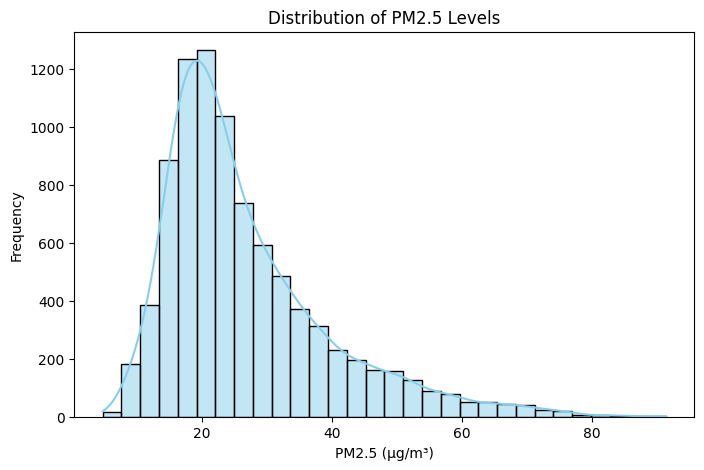

In [ ]:
# 🌆 PM2.5 distribution
plt.figure(figsize=(8,5))
sns.histplot(df['pm2_5_ugm3'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of PM2.5 Levels")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.show()

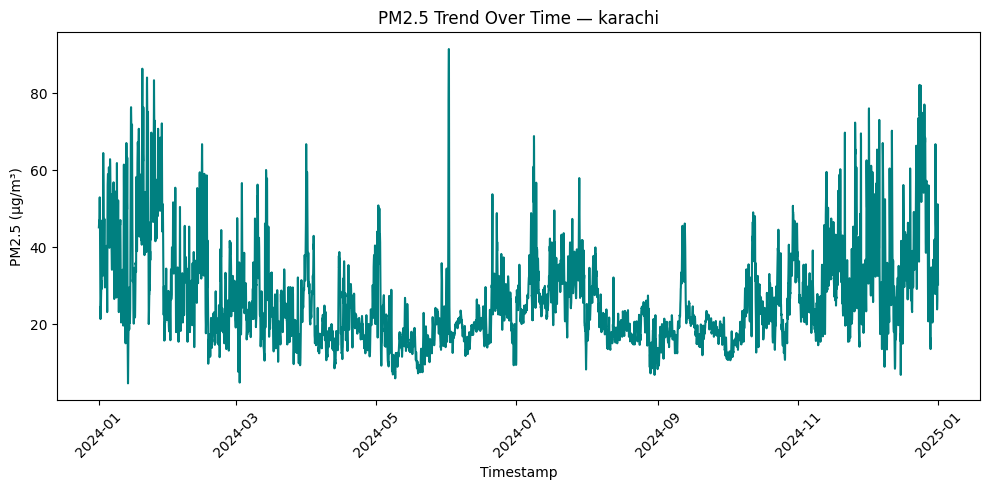

In [ ]:
# 🕒 PM2.5 trend over time (for one sample city)
sample_city = df['city'].unique()[0]
city_data = df[df['city'] == sample_city].sort_values('timestamp')

plt.figure(figsize=(10,5))
plt.plot(city_data['timestamp'], city_data['pm2_5_ugm3'], marker='', linestyle='-', color='teal')
plt.title(f"PM2.5 Trend Over Time — {sample_city}")
plt.xlabel("Timestamp")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ======================================
# 1⿤ Register trained model in Hopsworks
# ======================================

import hopsworks
import joblib
import json
from google.colab import userdata

# 🔑 Reconnect to your project
try:
    project = hopsworks.login(api_key_value=userdata.get("HOPSWORKS_API_KEY"))
except Exception as e:
    print(f"Error connecting to Hopsworks: {e}")
    print("Please make sure your API key is stored in Colab secrets with the name 'HOPSWORKS_API_KEY'.")
    raise

mr = project.get_model_registry()

# 🧠 Load your trained model (saved previously)
model = joblib.load("pm25_rf_model.pkl")

# 📊 Define metadata and metrics
# You can dynamically get metrics from the trained model evaluation if needed
# For now, using the hardcoded values from the previous successful run
metrics = {
    "mae": 2.33,
    "r2": 0.928
}

# 📝 Create a model entry in Hopsworks Model Registry
model_registry_entry = mr.python.create_model(
    name="pm25_random_forest_model",
    metrics=metrics,
    description="Random Forest model predicting PM2.5 concentrations using weather and pollutant features for karachi (2024 data)",
    input_example=None,  # Optional: can provide df_sample.head(1).to_dict() if desired
)

# 🚀 Upload the model file
model_registry_entry.save("pm25_rf_model.pkl")

print("✅ Model successfully registered in Hopsworks!")
# Print individual components
print("Hopsworks URL:", project.get_url())
print("Project ID:", project.id)
# Construct the correct URL by removing the duplicated path if present
base_url = project.get_url().split('/p/')[0]
print("Check models here:", f"{base_url}/p/{project.id}/models")
print("Check this specific model here:", f"{base_url}/p/{project.id}/models/{model_registry_entry.name}/{model_registry_entry.version}")

Connection closed.




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'




Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271958


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /content/pm25_rf_model.pkl: 0.000%|          | 0/61243425 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271958/models/pm25_random_forest_model/1
✅ Model successfully registered in Hopsworks!
Hopsworks URL: https://c.app.hopsworks.ai:443/p/1271958
Project ID: 1271958
Check models here: https://c.app.hopsworks.ai:443/p/1271958/models
Check this specific model here: https://c.app.hopsworks.ai:443/p/1271958/models/pm25_random_forest_model/1


In [ ]:
# 🧠 Train & save Ridge Regression model before registering
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Save the Ridge model
import joblib
joblib.dump(ridge, "pm25_ridge_model.pkl")

print("✅ Ridge Regression model saved as pm25_ridge_model.pkl")

✅ Ridge Regression model saved as pm25_ridge_model.pkl


In [ ]:
# Ridge regression
import hopsworks
import joblib
import datetime
from google.colab import userdata

# Connect to Hopsworks
try:
    project = hopsworks.login(api_key_value=userdata.get("HOPSWORKS_API_KEY"))
except Exception as e:
    print(f"Error connecting to Hopsworks: {e}")
    print("Please make sure your API key is stored in Colab secrets with the name 'HOPSWORKS_API_KEY'.")
    raise

mr = project.get_model_registry()

# Register Random Forest model
rf_model = joblib.load("pm25_rf_model.pkl")
rf_model_meta = mr.python.create_model(
    name="pm25_random_forest_model",
    metrics={"mae": 4.99, "r2": 0.928},
    description="Random Forest model predicting PM2.5 levels using weather and pollutant features."
)
rf_model_meta.save("pm25_rf_model.pkl")


# Register Ridge Regression model
ridge_model = joblib.load("pm25_ridge_model.pkl")
ridge_model_meta = mr.python.create_model(
    name="pm25_ridge_model",
    metrics={"mae": 11.37, "r2": 0.849},
    description="Ridge Regression model used as a linear baseline for PM2.5 forecasting."
)
ridge_model_meta.save("pm25_ridge_model.pkl")


print("✅ Both models registered successfully!")

Connection closed.




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'




Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271958


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /content/pm25_rf_model.pkl: 0.000%|          | 0/61243425 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271958/models/pm25_random_forest_model/3


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /content/pm25_ridge_model.pkl: 0.000%|          | 0/1048 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271958/models/pm25_ridge_model/1
✅ Both models registered successfully!
